# Libraries and definitions

In [1]:
import pandas as pd
import numpy as np
from os.path import join
from matplotlib import pyplot as plt
import sklearn
from sklearn import feature_selection
from sklearn.metrics import balanced_accuracy_score

In [2]:
DATA_DIR = 'data'
DATA_FILE = join(DATA_DIR,'covid_data_2.csv')

In [3]:
REF_DATE = pd.to_datetime('2022-01-01')
target_col = 'final_outcome_amp'

# Information extraction

In [4]:
def filter_data_date(data,reference_date = REF_DATE):
    '''For each person (record_id), get only the row with the visit date closest to reference_date'''
    data['visit_date'] = pd.to_datetime(data['visit_date'])
    data = data.dropna(subset=['visit_date'],ignore_index = True)
    data = data[data['visit_date'] < reference_date]
    return data.sort_values(by=['record_id','visit_date'],ascending = [True,False]).drop_duplicates(subset=['record_id'], keep='first')#.reset_index()


def analyze_dataframe(df, target_col):
    """
    Generates a comprehensive data report for a DataFrame
    
    Args:
        df (pd.DataFrame): Input DataFrame
        target_col (str): Name of target column
        
    Returns:
        dict: Dictionary containing data characteristics
    """
    report = {
        'dataset_shape': df.shape,
        'target_balance': df[target_col].value_counts(normalize=True).to_dict(),
        'columns': {},
        'missing_data': {},
        'high_missing_cols': [],
        'date_columns': [],
        'potential_leakage': [],
        'categorical_summary': {},
        'numerical_summary': {}
    }
    
    # Check target variable
    if target_col not in df.columns:
        raise ValueError(f"Target column {target_col} not found in DataFrame")
    
    # Analyze each column
    for col in df.columns:
        if col == target_col:
            continue
            
        col_type = df[col].dtype
        unique_count = df[col].nunique()
        missing_percent = df[col].isna().mean() * 100
        
        # Store basic info
        report['columns'][col] = {
            'dtype': str(col_type),
            'unique_values': unique_count,
            'missing_percent': round(missing_percent, 2)
        }
        
        # Track high missing columns
        if missing_percent > 30:
            report['high_missing_cols'].append((col, missing_percent))
            
        # Check for potential leakage
        if any(term in col.lower() for term in ['outcome', 'result', 'target', 'final']):
            report['potential_leakage'].append(col)
            
        # Detect date columns
        if np.issubdtype(df[col].dtype, np.datetime64):
            report['date_columns'].append(col)
        elif col_type == 'object':
            try:
                pd.to_datetime(df[col])
                report['date_columns'].append(col)
            except:
                pass
                
        # Categorical analysis
        if col_type == 'object' or unique_count < 20:
            top_categories = df[col].value_counts(normalize=True).head(5).to_dict()
            report['categorical_summary'][col] = {
                'unique_count': unique_count,
                'top_categories': {k: round(v, 4) for k, v in top_categories.items()}
            }
            
        # Numerical analysis
        if np.issubdtype(col_type, np.number):
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            
            num_stats = {
                'mean': round(df[col].mean(), 2),
                'median': round(df[col].median(), 2),
                'std': round(df[col].std(), 2),
                'outliers_iqr': round(((df[col] < (q1 - 1.5 * iqr)) | 
                                      (df[col] > (q3 + 1.5 * iqr))).mean() * 100, 2)
            }
            report['numerical_summary'][col] = num_stats
            
    
    # Sort high missing columns
    report['high_missing_cols'] = sorted(report['high_missing_cols'], 
                                        key=lambda x: x[1], reverse=True)
    
    return report


In [5]:
all_data = pd.read_csv(DATA_FILE)
raw_data = filter_data_date(all_data).dropna(axis=1, how='all') #apply date filter and remove empty columns
raw_data.set_index('record_id',inplace=True)
assert (all_data['record_id'].unique() == raw_data.index).all()

In [6]:
report = analyze_dataframe(raw_data, target_col)

# Print key insights
print(f"Dataset Shape: {report['dataset_shape']}")
print(f"\nTarget Balance: {report['target_balance']}")

print("\nHigh Missing Columns (>30%):")
for col, percent in report['high_missing_cols']:
    print(f"- {col}: {percent}% missing")
    
print("\nPotential Date Columns:")
print(report['date_columns'])

print("\nPotential Leakage Columns:")
print(report['potential_leakage'])

Dataset Shape: (710, 69)

Target Balance: {0: 0.6281690140845071, 1: 0.37183098591549296}

High Missing Columns (>30%):
- vaccine_date_4: 99.43661971830986% missing
- vaccine_type_4: 99.43661971830986% missing
- pcr_pos_date_2: 99.15492957746478% missing
- pcr_pos_sev_1: 98.45070422535211% missing
- symp_sev_init_3l: 59.71830985915493% missing
- vaccine_type_3: 59.436619718309856% missing
- vaccine_date_3: 59.29577464788732% missing
- symp_init: 51.12676056338028% missing
- symp_count_init_3l: 51.12676056338028% missing
- hosp_2wks: 51.12676056338028% missing
- icu_2wks: 51.12676056338028% missing
- pcr_pos_date_1: 49.29577464788733% missing
- prior_pos_pcr: 48.87323943661972% missing

Potential Date Columns:
['visit_date', 'index_date', 'first_exposure_date', 'vaccine_date_1', 'vaccine_date_2', 'vaccine_date_3', 'vaccine_date_4', 'pcr_pos_date_1', 'pcr_pos_date_2']

Potential Leakage Columns:
['ab_chuv_iga_result', 'ab_chuv_igg_s_result', 'ab_chuv_igg_n_result']


/disk/users/lprate/mytmp/ipykernel_87249/836792677.py:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df[col])
/disk/users/lprate/mytmp/ipykernel_87249/836792677.py:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df[col])
/disk/users/lprate/mytmp/ipykernel_87249/836792677.py:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df[col])
/disk/users/lprate/mytmp/ipykernel_87249/836792677.py:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consist

# Preprocess data

In [7]:
y = raw_data.pop('final_outcome_amp')
raw_data.head()

,Unnamed: 0,timepoint,study,pop_sample,visit_date,index_date,age,sex,bmi,smoking,...,last_antibody_before_omicron_igg_s_logratio,last_antibody_before_omicron_iga_log10ratio,last_antibody_before_omicron_igg_n_log10ratio,last_antibody_before_omicron_igg_s_log10ratio,last_antibody_before_omicron_iga_ratio,last_antibody_before_omicron_igg_n_ratio,last_antibody_before_omicron_igg_s_ratio,prior_hyg,prior_dist,prior_mask_mand
record_id,,,,,,,,,,,,,,,,,,,,,
1,4,M12,ZSAC,prospective,2021-08-05,2020-08-06,23,female,24.618104,Non-smoker,...,3.887730,0.416300,0.000000,1.688420,2.607955,1.0,48.8,7.0,2.0,7.0
2,11,M12,ZSAC,prospective,2021-08-06,2020-08-06,51,male,26.643599,Ex-smoker,...,3.772761,0.547579,0.000000,1.638489,3.528409,1.0,43.5,7.0,6.0,7.0
3,18,M12,ZSAC,prospective,2021-08-16,2020-08-06,36,male,23.190497,Non-smoker,...,4.409155,1.654363,0.000000,1.914872,45.119318,1.0,82.2,7.0,5.0,7.0
5,25,M12,ZSAC,prospective,2021-08-10,2020-08-06,53,female,21.147691,Non-smoker,...,4.036009,0.893421,0.000000,1.752816,7.823864,1.0,56.6,6.0,6.0,7.0
8,32,M12,ZSAC,prospective,2021-08-09,2020-08-08,32,female,23.634033,Non-smoker,...,4.442651,1.409145,0.230449,1.929419,25.653409,1.7,85.0,7.0,4.0,7.0


In [8]:
raw_data['diabetes'].dropna().unique()

array(['No', 'Yes'], dtype=object)

## Convert variables

In [9]:
def scale(x:pd.Series):
    if SCALE: return (x - x.mean()) / x.std()
    else: return x

In [10]:
def scale(data):
    return data
    return (data - data.mean())/data.std()
def preprocess_data(df):
    data = df.copy().drop(columns=['Unnamed: 0', 'visit_date'])
    data['index_date'] = (REF_DATE - pd.to_datetime(data['index_date'], format='%Y-%m-%d')).dt.days; 
    data['study'] = data['study'].fillna(data['study'].mode()[0]).map({data['study'].dropna().unique()[0]:0, data['study'].dropna().unique()[1]:1})
    data['timepoint'] = data['timepoint'].fillna(data['timepoint'].mode()[0]).map({data['timepoint'].dropna().unique()[0]:0, data['timepoint'].dropna().unique()[1]:1})
    data = pd.get_dummies(data, columns=['pop_sample'], dtype=int)
    data['age'] = scale(data['age'])#normalize age?
    data['sex'] = data['sex'].fillna(data['sex'].mode()[0]).map({data['sex'].dropna().unique()[0]:0, data['sex'].dropna().unique()[1]:1})
    data['bmi'] = scale(data['bmi']).fillna(data['bmi'].mean())
    data['smoking'] = data['smoking'].fillna(data['smoking'].mode()[0]).map({'Non-smoker': 0, 'Ex-smoker': 1, 'Smoker': 2})
    data['comorbidity'] = data['comorbidity'].fillna(data['comorbidity'].mode()[0]).map({data['comorbidity'].dropna().unique()[0]:0, data['comorbidity'].dropna().unique()[1]:1})
    data['hypertension'] = data['hypertension'].fillna(data['hypertension'].mode()[0]).map({data['hypertension'].dropna().unique()[0]:0, data['hypertension'].dropna().unique()[1]:1})
    data['diabetes'] = data['diabetes'].fillna(data['diabetes'].mode()[0]).map({data['diabetes'].dropna().unique()[0]:0, data['diabetes'].dropna().unique()[1]:1})
    data['cvd'] = data['cvd'].fillna(data['cvd'].mode()[0]).map({data['cvd'].dropna().unique()[0]:0, data['cvd'].dropna().unique()[1]:1})
    data['respiratory'] = data['respiratory'].fillna(data['respiratory'].mode()[0]).map({data['respiratory'].dropna().unique()[0]:0, data['respiratory'].dropna().unique()[1]:1})
    data['ckd'] = data['ckd'].fillna(data['ckd'].mode()[0]).map({data['ckd'].dropna().unique()[0]:0, data['ckd'].dropna().unique()[1]:1})
    data['cancer'] = data['cancer'].fillna(data['cancer'].mode()[0]).map({data['cancer'].dropna().unique()[0]:0, data['cancer'].dropna().unique()[1]:1})
    data['immune_supp'] = data['immune_supp'].fillna(data['immune_supp'].mode()[0]).map({data['immune_supp'].dropna().unique()[0]:0, data['immune_supp'].dropna().unique()[1]:1})
    data['income_3l'] = data['income_3l'].fillna(data['income_3l'].mode()[0]).map({"<6'000 CHF": 0, "6'000 - 12'000 CHF": 1, ">12'000 CHF": 2})
    data = pd.get_dummies(data, columns=['employment_4l'], dtype=int)
    data['education_4l'] = data['education_4l'].fillna(data['education_4l'].mode()[0]).map({
        'None or mandatory school': 0,
        'Vocational training or specialized baccalaureate': 1,
        'Higher technical school or college': 2,
        'University': 3
    })
    data['nationality'] = data['nationality'].fillna(data['nationality'].mode()[0]).map({'Non-Swiss':0,'Swiss':1})
    data['summary_bl_behaviour'] = scale(data['summary_bl_behaviour'])
    data['symp_init'] = data['symp_init'].fillna(data['symp_init'].mode()[0]).map({"No":0, "Yes":1})
    data['symp_count_init_3l'] = data['symp_count_init_3l'].fillna(data['symp_count_init_3l'].mode()[0]).map({
        'Asymptomatic': 0,
        '1-5 symptoms': 1,
        '≥6 symptoms': 2
    })
    data['symp_sev_init_3l'] = data['symp_sev_init_3l'].fillna(data['symp_sev_init_3l'].mode()[0]).map({"Mild to moderate":0, "Severe to very severe":1})
    data['hosp_2wks'] = data['hosp_2wks'].fillna(data['hosp_2wks'].mode()[0]).map({"No":0, "Yes":1})
    data['icu_2wks'] = data['icu_2wks'].fillna(data['icu_2wks'].mode()[0]).map({"No":0, "Yes":1}) #can discard?
    data['seropos_at_bl'] = data['seropos_at_bl'].fillna(data['seropos_at_bl'].mode()[0]).map({"No":0, "Yes":1})
    data['prior_pos_pcr'] = data['prior_pos_pcr'].fillna(data['prior_pos_pcr'].mode()[0]).map({"No":0, "Yes":1})
    data['prior_exposure'] = data['prior_exposure'].fillna(data['prior_exposure'].mode()[0]).map({"No":0, "Yes":1})
    data['first_exposure_date'] = (REF_DATE - pd.to_datetime(data['first_exposure_date'], format='%Y-%m-%d')).dt.days; 
    data['first_exposure_date'] = data['first_exposure_date'].fillna(-100)
    data['first_exposure'] = data['first_exposure'].fillna(data['first_exposure'].mode()[0]).map({data['first_exposure'].dropna().unique()[0]:0, data['first_exposure'].dropna().unique()[1]:1})
    data= pd.get_dummies(data,columns=['vaccine_type_1'], dummy_na=0, dtype=int)#data['vaccine_type_1'].map({"Moderna":0, "Pfizer/BioNTech":1, "Other":0.5}).fillna(-1) 
    data = pd.get_dummies(data,columns=['vaccine_type_2'], dummy_na=0, dtype=int)#data['vaccine_type_2'].map({"Moderna":0, "Pfizer/BioNTech":1, "Other":0.5}).fillna(-1)
    data = pd.get_dummies(data,columns=['vaccine_type_3'], dummy_na=0, dtype=int)#data['vaccine_type_3'].map({"Moderna":0, "Pfizer/BioNTech":1, "Other":0.5}).fillna(-1)
    data = pd.get_dummies(data,columns=['vaccine_type_4'], dummy_na=0, dtype=int)#data['vaccine_type_4'].map({"Moderna":0, "Pfizer/BioNTech":1, "Other":0.5}).fillna(-1) 
    data['pcr_pos_date_1'] = (REF_DATE - pd.to_datetime(data['pcr_pos_date_1'], format='%Y-%m-%d')).dt.days.fillna(-100); 
    data['pcr_pos_date_1'] = data['pcr_pos_date_1'].fillna(data['pcr_pos_date_1'].mean())
    data['pcr_pos_date_2'] = (REF_DATE - pd.to_datetime(data['pcr_pos_date_2'], format='%Y-%m-%d')).dt.days.fillna(-100)
    data['pcr_pos_sev_1'] = data['pcr_pos_sev_1'].fillna(data['pcr_pos_sev_1'].mode()[0]).map({"Very mild": 1, "Mild": 2, "Moderate": 3, "Severe": 4})
    data['ab_chuv_iga_ratio'] = scale(data['ab_chuv_iga_ratio'])
    data['ab_chuv_iga_result'] = data['ab_chuv_iga_result'].fillna(data['ab_chuv_iga_result'].mode()[0]).map({data['ab_chuv_iga_result'].dropna().unique()[0]:0, data['ab_chuv_iga_result'].dropna().unique()[1]:1})
    data['ab_chuv_igg_s_ratio'] = scale(data['ab_chuv_igg_s_ratio'])
    data['ab_chuv_igg_s_result'] = data['ab_chuv_igg_s_result'].fillna(data['ab_chuv_igg_s_result'].mode()[0]).map({data['ab_chuv_igg_s_result'].dropna().unique()[0]:0, data['ab_chuv_igg_s_result'].dropna().unique()[1]:1})
    data['ab_chuv_igg_n_ratio'] = scale(data['ab_chuv_igg_n_ratio'])
    data['ab_chuv_igg_n_result'] = data['ab_chuv_igg_n_result'].fillna(data['ab_chuv_igg_n_result'].mode()[0]).map({data['ab_chuv_igg_n_result'].dropna().unique()[0]:0, data['ab_chuv_igg_n_result'].dropna().unique()[1]:1})
    data['last_antibody_before_omicron_iga_logratio'] = scale(data['last_antibody_before_omicron_iga_logratio'])
    data['ab_chuv_iga_logratio'] = scale(data['ab_chuv_iga_logratio'])
    data['ab_chuv_igg_s_logratio'] = scale(data['ab_chuv_igg_s_logratio'])
    data['ab_chuv_igg_n_logratio'] = scale(data['ab_chuv_igg_n_logratio'])
    
    # Drop the ratio columns
    data.drop(columns=['ab_chuv_iga_ratio', 'ab_chuv_igg_s_ratio', 'ab_chuv_igg_n_ratio'], inplace=True)
    data['last_antibody_before_omicron_igg_n_logratio'] = scale(data['last_antibody_before_omicron_igg_n_logratio'])
    data['last_antibody_before_omicron_igg_s_logratio'] = scale(data['last_antibody_before_omicron_igg_s_logratio'])
    data['vaccine_date_1'] = (REF_DATE - pd.to_datetime(data['vaccine_date_1'], format='%Y-%m-%d')).dt.days; 
    data['vaccine_date_1'] = data['vaccine_date_1'].fillna(-100)
    data['vaccine_date_2'] = (REF_DATE - pd.to_datetime(data['vaccine_date_2'], format='%Y-%m-%d')).dt.days
    data['vaccine_date_2'] = data['vaccine_date_2'].fillna(-100); 
    data['vaccine_date_3'] = (REF_DATE - pd.to_datetime(data['vaccine_date_3'], format='%Y-%m-%d')).dt.days; 
    data['vaccine_date_3'] = data['vaccine_date_3'].fillna(-100)
    data['vaccine_date_4'] = (REF_DATE - pd.to_datetime(data['vaccine_date_4'], format='%Y-%m-%d')).dt.days; 
    data['vaccine_date_4'] = data['vaccine_date_4'].fillna(-100)
    data['prior_hyg'] = data['prior_hyg'].fillna(data['prior_hyg'].mode()[0])
    data['prior_dist'] = data['prior_dist'].fillna(data['prior_dist'].mode()[0])
    data['prior_mask_mand'] = data['prior_mask_mand'].fillna(data['prior_mask_mand'].mode()[0])
    data["most_recent_vaccine"] = raw_data[['vaccine_date_4', 'vaccine_date_3', 'vaccine_date_2', 'vaccine_date_1']].bfill(axis=1).iloc[:, 0]
    data["most_recent_vaccine"] = (REF_DATE - pd.to_datetime(data["most_recent_vaccine"], format='%Y-%m-%d')).dt.days.fillna(-100)
    data['num_vaccines'] = raw_data[['vaccine_date_1', 'vaccine_date_2', 'vaccine_date_3', 'vaccine_date_4']].notna().sum(axis=1)
    
    return data

In [11]:
data = preprocess_data(raw_data)

In [12]:
print(f"Final dataset shape: {data.shape}")
print("\nMissing values:", data.isna().sum().sum())
print("Column dtypes:\n", data.dtypes.value_counts())
print("\nTarget distribution:\n", y.value_counts(normalize=True))

Final dataset shape: (710, 77)

Missing values: 0
Column dtypes:
 int64      49
float64    28
Name: count, dtype: int64

Target distribution:
 final_outcome_amp
0    0.628169
1    0.371831
Name: proportion, dtype: float64


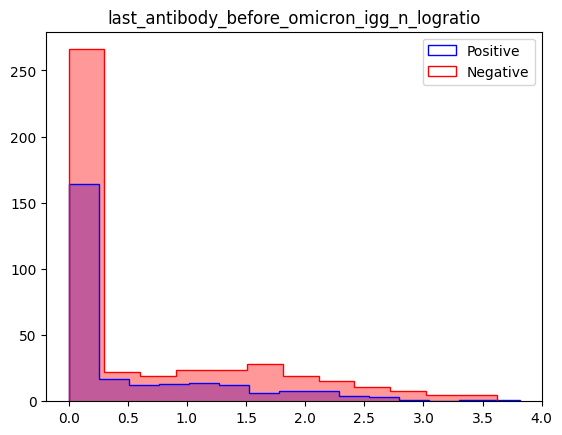

In [34]:
density = False
plt.hist(data['last_antibody_before_omicron_igg_n_logratio'][y==1],histtype='step', bins = 'auto', color = 'blue', density=density, label = 'Positive')
plt.hist(data['last_antibody_before_omicron_igg_n_logratio'][y==1],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='blue', density=density)
plt.hist(data['last_antibody_before_omicron_igg_n_logratio'][y==0],histtype='step', bins = 'auto', color = 'red', density=density, label='Negative')
plt.hist(data['last_antibody_before_omicron_igg_n_logratio'][y==0],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='red', density=density)
plt.legend()
#plt.xlim(0,10)
plt.title('last_antibody_before_omicron_igg_n_logratio')
plt.show()


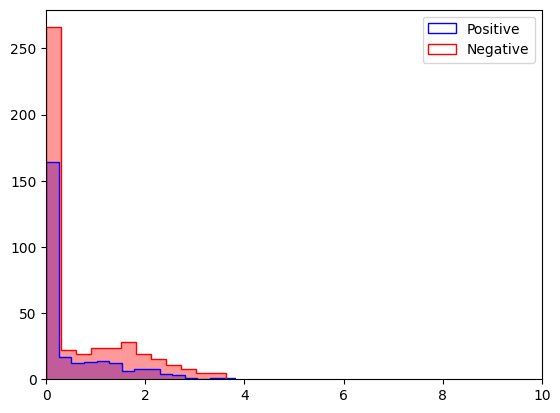

In [33]:
density = False
plt.hist(data['ab_chuv_igg_n_logratio'][y==1],histtype='step', bins = 'auto', color = 'blue', density=density, label = 'Positive')
plt.hist(data['ab_chuv_igg_n_logratio'][y==1],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='blue', density=density)
plt.hist(data['ab_chuv_igg_n_logratio'][y==0],histtype='step', bins = 'auto', color = 'red', density=density, label='Negative')
plt.hist(data['ab_chuv_igg_n_logratio'][y==0],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='red', density=density)
plt.legend()
plt.xlim(0,10)
plt.show()


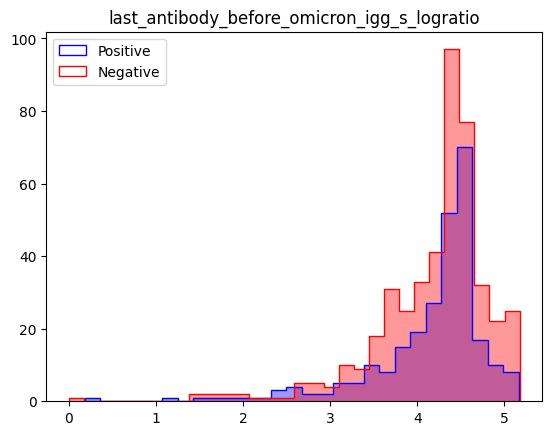

In [36]:
density = False
plt.hist(data['ab_chuv_igg_s_logratio'][y==1],histtype='step', bins = 'auto', color = 'blue', density=density, label = 'Positive')
plt.hist(data['ab_chuv_igg_s_logratio'][y==1],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='blue', density=density)
plt.hist(data['ab_chuv_igg_s_logratio'][y==0],histtype='step', bins = 'auto', color = 'red', density=density, label='Negative')
plt.hist(data['ab_chuv_igg_s_logratio'][y==0],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='red', density=density)
plt.legend()
#plt.xlim(0,10)
plt.title('last_antibody_before_omicron_igg_s_logratio')
plt.show()

In [16]:
raw_data["last_antibody_before_omicron_iga_logratio"].isna().sum()

0

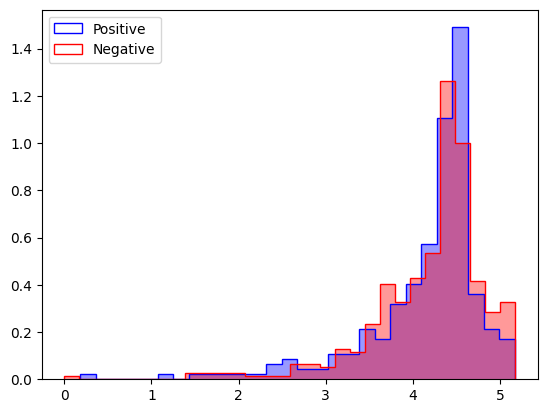

In [17]:
density = True
plt.hist(data['last_antibody_before_omicron_igg_s_logratio'][y==1],histtype='step', bins = 'auto', color = 'blue', density=density, label = 'Positive')
plt.hist(data['last_antibody_before_omicron_igg_s_logratio'][y==1],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='blue', density=density)
plt.hist(data['last_antibody_before_omicron_igg_s_logratio'][y==0],histtype='step', bins = 'auto', color = 'red', density=density, label='Negative')
plt.hist(data['last_antibody_before_omicron_igg_s_logratio'][y==0],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='red', density=density)
plt.legend()
#plt.xlim(0,10)
plt.show()

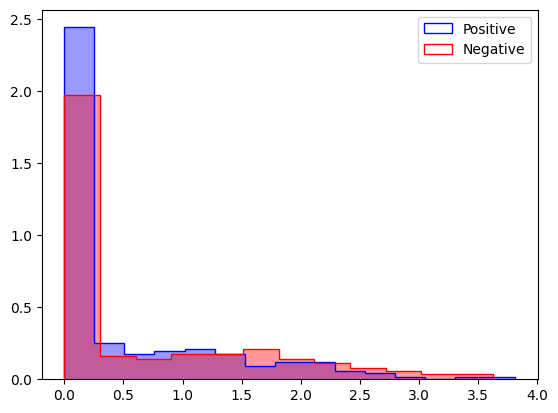

In [ ]:
density = True
plt.hist(data['last_antibody_before_omicron_igg_n_logratio'][y==1],histtype='step', bins = 'auto', color = 'blue', density=density, label = 'Positive')
plt.hist(data['last_antibody_before_omicron_igg_n_logratio'][y==1],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='blue', density=density)
plt.hist(data['last_antibody_before_omicron_igg_n_logratio'][y==0],histtype='step', bins = 'auto', color = 'red', density=density, label='Negative')
plt.hist(data['last_antibody_before_omicron_igg_n_logratio'][y==0],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='red', density=density)
plt.legend()
#plt.xlim(0,10)
plt.show()

In [29]:
y_pred = data['last_antibody_before_omicron_igg_n_logratio'] < 0.5
accuracy = (y_pred == y).mean()
balanced_accuracy = balanced_accuracy_score(y, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")

Accuracy: 0.49
Balanced Accuracy: 0.53


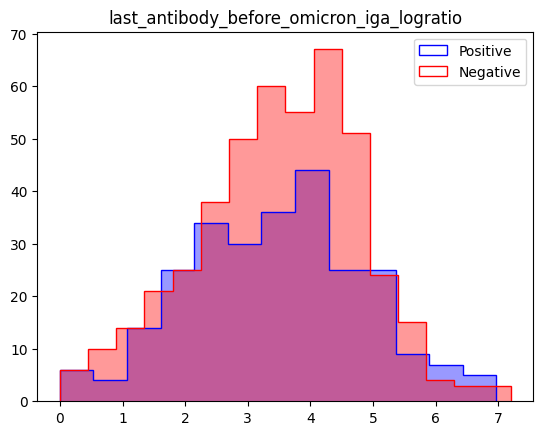

In [38]:
density = False
plt.hist(data['last_antibody_before_omicron_iga_logratio'][y==1],histtype='step', bins = 'auto', color = 'blue', density=density, label = 'Positive')
plt.hist(data['last_antibody_before_omicron_iga_logratio'][y==1],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='blue', density=density)
plt.hist(data['last_antibody_before_omicron_iga_logratio'][y==0],histtype='step', bins = 'auto', color = 'red', density=density, label='Negative')
plt.hist(data['last_antibody_before_omicron_iga_logratio'][y==0],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='red', density=density)
plt.legend()
#plt.xlim(0,10)
plt.title('last_antibody_before_omicron_iga_logratio')
plt.show()

In [24]:
y_pred = data['last_antibody_before_omicron_iga_logratio'] < 4
accuracy = (y_pred == y).mean()
balanced_accuracy = balanced_accuracy_score(y, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")

Accuracy: 0.48
Balanced Accuracy: 0.51


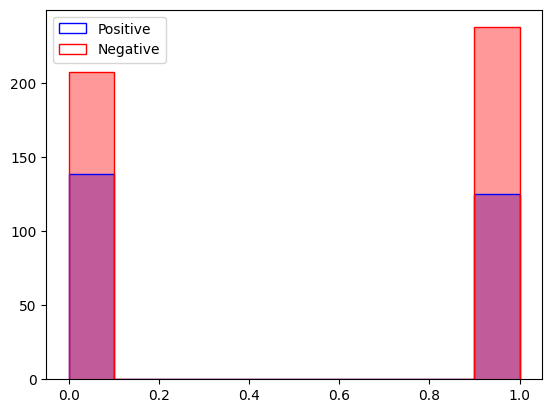

In [20]:
density = False
plt.hist(data['study'][y==1],histtype='step', bins = 'auto', color = 'blue', density=density, label = 'Positive')
plt.hist(data['study'][y==1],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='blue', density=density)
plt.hist(data['study'][y==0],histtype='step', bins = 'auto', color = 'red', density=density, label='Negative')
plt.hist(data['study'][y==0],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='red', density=density)
plt.legend()
plt.show()

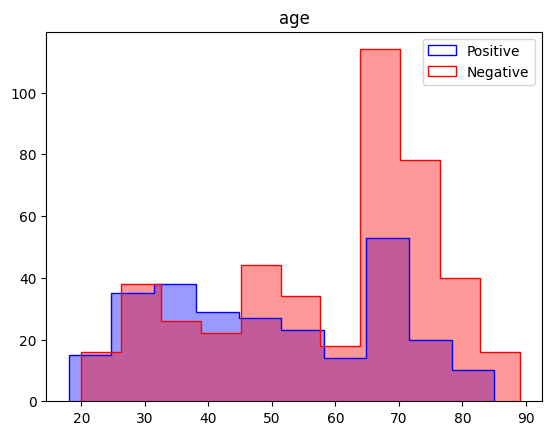

In [39]:
density = False#True
plt.hist(data['age'][y==1],histtype='step', bins = 'auto', color = 'blue', density=density, label = 'Positive')
plt.hist(data['age'][y==1],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='blue', density=density)
plt.hist(data['age'][y==0],histtype='step', bins = 'auto', color = 'red', density=density, label='Negative')
plt.hist(data['age'][y==0],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='red', density=density)
plt.legend()
plt.title('age')
plt.show()

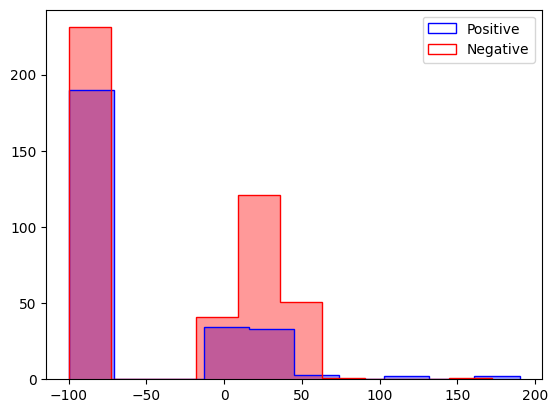

In [22]:
density = False#True
plt.hist(data['vaccine_date_3'][y==1],histtype='step', bins = 'auto', color = 'blue', density=density, label = 'Positive')
plt.hist(data['vaccine_date_3'][y==1],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='blue', density=density)
plt.hist(data['vaccine_date_3'][y==0],histtype='step', bins = 'auto', color = 'red', density=density, label='Negative')
plt.hist(data['vaccine_date_3'][y==0],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='red', density=density)
plt.legend()
plt.show()

In [23]:
data['pcr_pos_date_1']

record_id
1       513.0
2       513.0
3       513.0
5       513.0
8       511.0
        ...  
5409   -100.0
5410   -100.0
5411   -100.0
5413   -100.0
5417   -100.0
Name: pcr_pos_date_1, Length: 710, dtype: float64

In [53]:
most_recent_vaccine = raw_data[['vaccine_date_4', 'vaccine_date_3', 'vaccine_date_2', 'vaccine_date_1']].bfill(axis=1).iloc[:, 0]
most_recent_vaccine = (REF_DATE - pd.to_datetime(most_recent_vaccine, format='%Y-%m-%d')).dt.days.fillna(-100)

most_recent_infection = raw_data[['pcr_pos_date_2', 'pcr_pos_date_1']].bfill(axis=1).iloc[:, 0]
most_recent_infection = (REF_DATE - pd.to_datetime(most_recent_infection, format='%Y-%m-%d')).dt.days.fillna(-100)

most_recent_contact = raw_data[['pcr_pos_date_2', 'pcr_pos_date_1', 'vaccine_date_4', 'vaccine_date_3', 'vaccine_date_2', 'vaccine_date_1']].bfill(axis=1).iloc[:, 0]
most_recent_contact = (REF_DATE - pd.to_datetime(most_recent_contact, format='%Y-%m-%d')).dt.days.fillna(-100)

data['most_recent_vaccine'] = most_recent_vaccine
data['most_recent_infection'] = most_recent_infection
data['most_recent_contact'] = most_recent_contact

delta_t = (pd.to_datetime(raw_data['pcr_pos_date_1'], format='%Y-%m-%d') - pd.to_datetime(raw_data['vaccine_date_1'], format='%Y-%m-%d')).dt.days.fillna(500)
data['delta_t'] = delta_t


In [54]:
pcr_pos_date = (REF_DATE - pd.to_datetime(raw_data['pcr_pos_date_1'], format='%Y-%m-%d')).dt.days.fillna(-100)

In [55]:
raw_data['first_exposure'].value_counts()

first_exposure
Infection      390
Vaccination    320
Name: count, dtype: int64

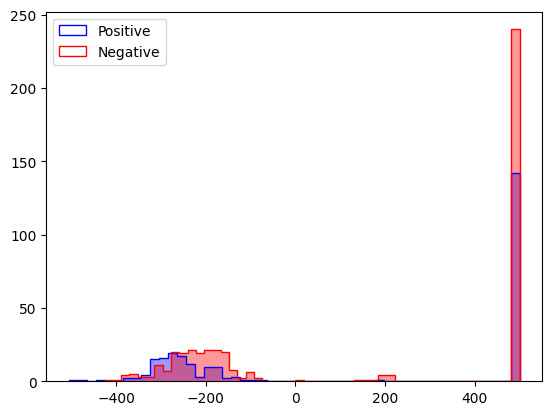

In [56]:
density = False#True
bins = 50
plt.hist(data['delta_t'][y==1],histtype='step', bins = bins, color = 'blue', density=density, label = 'Positive')
plt.hist(data['delta_t'][y==1],histtype='stepfilled', bins = bins, alpha = 0.4, color='blue', density=density)
plt.hist(data['delta_t'][y==0],histtype='step', bins = bins, color = 'red', density=density, label='Negative')
plt.hist(data['delta_t'][y==0],histtype='stepfilled', bins = bins, alpha = 0.4, color='red', density=density)
plt.legend()
plt.show()

In [57]:
y_pred = data['delta_t'] < -250
accuracy = (y_pred == y).mean()
balanced_accuracy = balanced_accuracy_score(y, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")

Accuracy: 0.64
Balanced Accuracy: 0.57


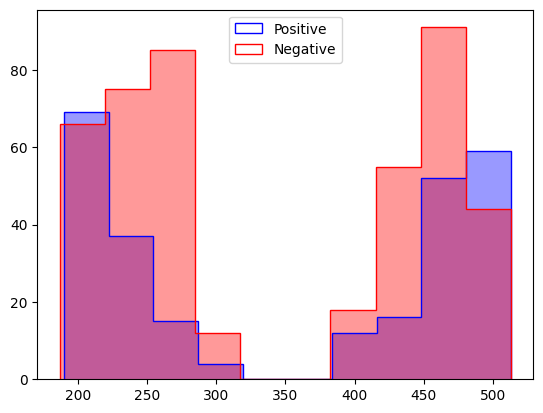

In [58]:
density = False#True
plt.hist(data['index_date'][y==1],histtype='step', bins = 'auto', color = 'blue', density=density, label = 'Positive')
plt.hist(data['index_date'][y==1],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='blue', density=density)
plt.hist(data['index_date'][y==0],histtype='step', bins = 'auto', color = 'red', density=density, label='Negative')
plt.hist(data['index_date'][y==0],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='red', density=density)
plt.legend()
plt.show()

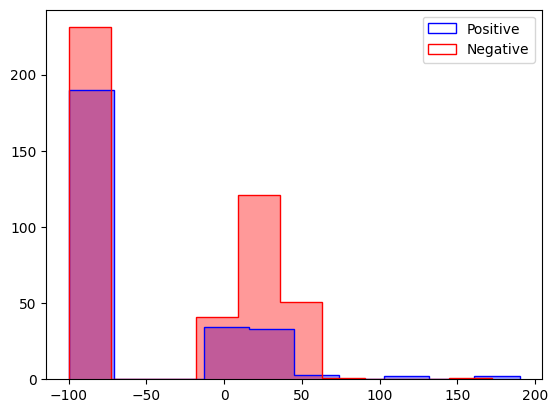

In [59]:
density = False#True
plt.hist(data['vaccine_date_3'][y==1],histtype='step', bins = 'auto', color = 'blue', density=density, label = 'Positive')
plt.hist(data['vaccine_date_3'][y==1],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='blue', density=density)
plt.hist(data['vaccine_date_3'][y==0],histtype='step', bins = 'auto', color = 'red', density=density, label='Negative')
plt.hist(data['vaccine_date_3'][y==0],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='red', density=density)
plt.legend()
plt.show()

In [60]:
raw_data[raw_data['study']=='ZVAC']['pcr_pos_date_1']

record_id
5001    NaN
5002    NaN
5003    NaN
5004    NaN
5005    NaN
       ... 
5409    NaN
5410    NaN
5411    NaN
5413    NaN
5417    NaN
Name: pcr_pos_date_1, Length: 363, dtype: object

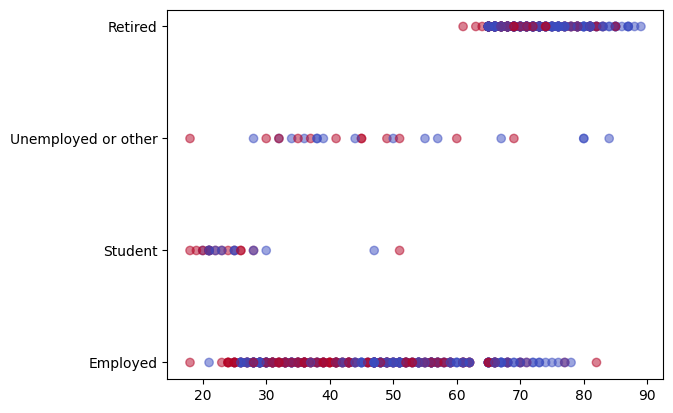

In [61]:
plt.scatter(data['age'], raw_data['employment_4l'], c=y, cmap='coolwarm', alpha=0.5)

In [62]:
columns_to_check = ['comorbidity', 'hypertension', 'diabetes', 'cvd', 'respiratory', 'ckd', 'cancer', 'immune_supp']

for column in columns_to_check:
    print(f"Value counts for {column}:")
    print(raw_data[column].value_counts())
    print("\n")

Value counts for comorbidity:
comorbidity
No     486
Yes    224
Name: count, dtype: int64


Value counts for hypertension:
hypertension
No     578
Yes    129
Name: count, dtype: int64


Value counts for diabetes:
diabetes
No     667
Yes     21
Name: count, dtype: int64


Value counts for cvd:
cvd
No     648
Yes     47
Name: count, dtype: int64


Value counts for respiratory:
respiratory
No     644
Yes     49
Name: count, dtype: int64


Value counts for ckd:
ckd
No     692
Yes      4
Name: count, dtype: int64


Value counts for cancer:
cancer
No     652
Yes     45
Name: count, dtype: int64


Value counts for immune_supp:
immune_supp
No     678
Yes     13
Name: count, dtype: int64




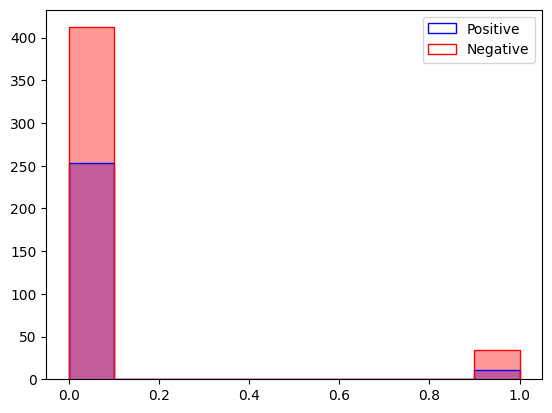

In [63]:
density = False#True
plt.hist(data['cancer'][y==1],histtype='step', bins = 'auto', color = 'blue', density=density, label = 'Positive')
plt.hist(data['cancer'][y==1],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='blue', density=density)
plt.hist(data['cancer'][y==0],histtype='step', bins = 'auto', color = 'red', density=density, label='Negative')
plt.hist(data['cancer'][y==0],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='red', density=density)
plt.legend()
plt.show()

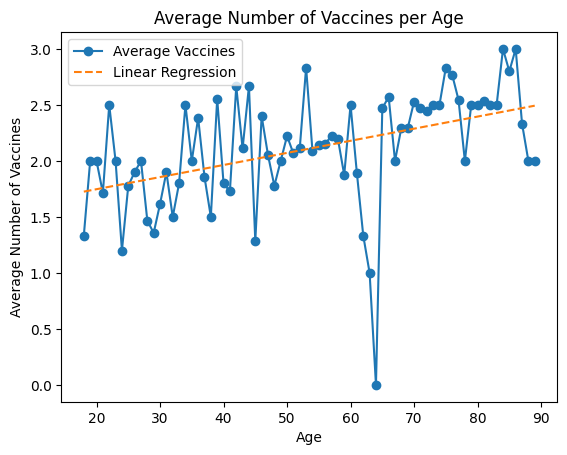

In [64]:
from scipy.stats import linregress

avg_vaccines_per_age = data.groupby('age')['num_vaccines'].mean()
slope, intercept, r_value, p_value, std_err = linregress(avg_vaccines_per_age.index, avg_vaccines_per_age.values)

plt.plot(avg_vaccines_per_age.index, avg_vaccines_per_age.values, marker='o', label='Average Vaccines')
plt.plot(avg_vaccines_per_age.index, intercept + slope * avg_vaccines_per_age.index, linestyle='--', label='Linear Regression')
plt.xlabel('Age')
plt.ylabel('Average Number of Vaccines')
plt.title('Average Number of Vaccines per Age')
plt.legend()
plt.show()

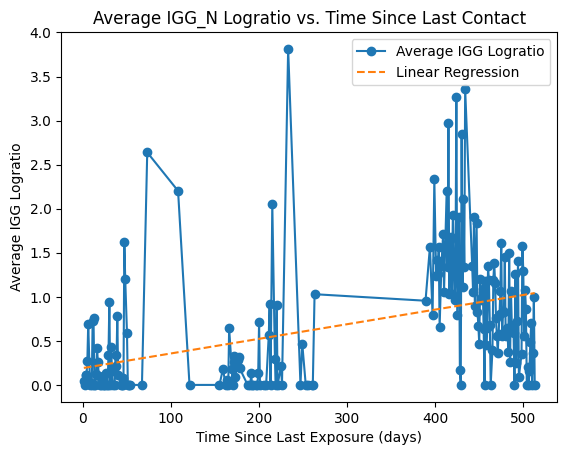

In [101]:
from scipy.stats import linregress

avg_vaccines_per_time = data.groupby('most_recent_contact')['ab_chuv_igg_n_logratio'].mean()
slope, intercept, r_value, p_value, std_err = linregress(avg_vaccines_per_time.index, avg_vaccines_per_time.values)

plt.plot(avg_vaccines_per_time.index, avg_vaccines_per_time.values, marker='o', label='Average IGG Logratio')
plt.plot(avg_vaccines_per_time.index, intercept + slope * avg_vaccines_per_time.index, linestyle='--', label='Linear Regression')
plt.xlabel('Time Since Last Exposure (days)')
plt.ylabel('Average IGG Logratio')
plt.title('Average IGG_N Logratio vs. Time Since Last Contact')
plt.legend()
plt.show()

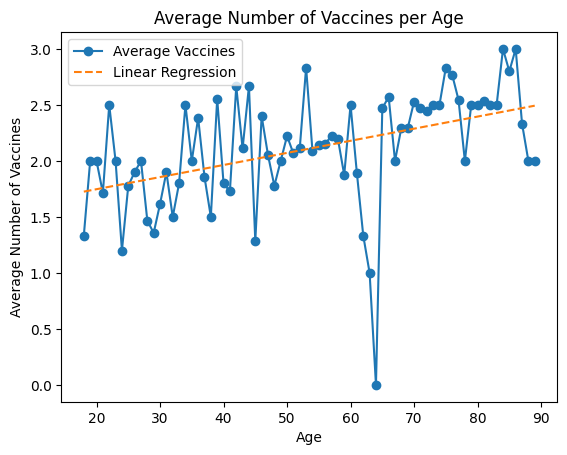

In [66]:
from scipy.stats import linregress

avg_vaccines_per_age = data.groupby('age')['num_vaccines'].mean()
slope, intercept, r_value, p_value, std_err = linregress(avg_vaccines_per_age.index, avg_vaccines_per_age.values)

plt.plot(avg_vaccines_per_age.index, avg_vaccines_per_age.values, marker='o', label='Average Vaccines')
plt.plot(avg_vaccines_per_age.index, intercept + slope * avg_vaccines_per_age.index, linestyle='--', label='Linear Regression')
plt.xlabel('Age')
plt.ylabel('Average Number of Vaccines')
plt.title('Average Number of Vaccines per Age')
plt.legend()
plt.show()

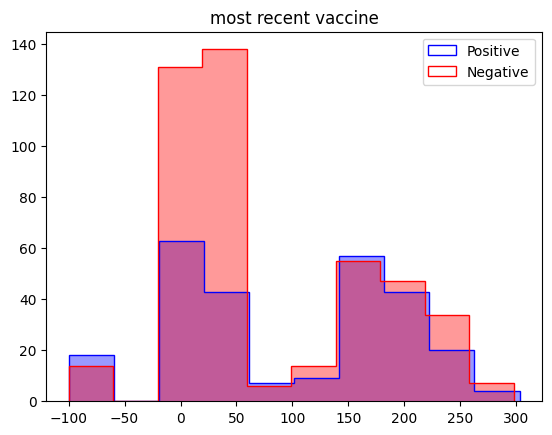

In [92]:
density = False#True
plt.hist(most_recent_vaccine[y==1],histtype='step', bins = 'auto', color = 'blue', density=density, label = 'Positive')
plt.hist(most_recent_vaccine[y==1],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='blue', density=density)
plt.hist(most_recent_vaccine[y==0],histtype='step', bins = 'auto', color = 'red', density=density, label='Negative')
plt.hist(most_recent_vaccine[y==0],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='red', density=density)
plt.legend()
plt.title('most recent vaccine')
plt.show()

In [68]:
y_pred = (most_recent_vaccine < 0) | ((most_recent_vaccine > 115) & (most_recent_vaccine <210))
accuracy = (y_pred == y).mean()
balanced_accuracy = balanced_accuracy_score(y, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")

Accuracy: 0.64
Balanced Accuracy: 0.60


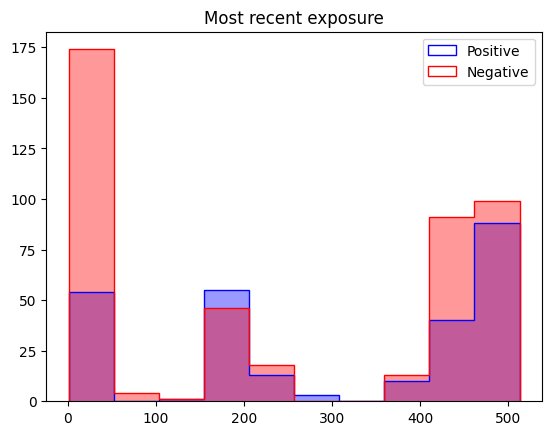

In [69]:
density = False#True
plt.hist(most_recent_contact[y==1],histtype='step', bins = 'auto', color = 'blue', density=density, label = 'Positive')
plt.hist(most_recent_contact[y==1],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='blue', density=density)
plt.hist(most_recent_contact[y==0],histtype='step', bins = 'auto', color = 'red', density=density, label='Negative')
plt.hist(most_recent_contact[y==0],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='red', density=density)
plt.legend()
plt.title('Most recent exposure')
plt.show()

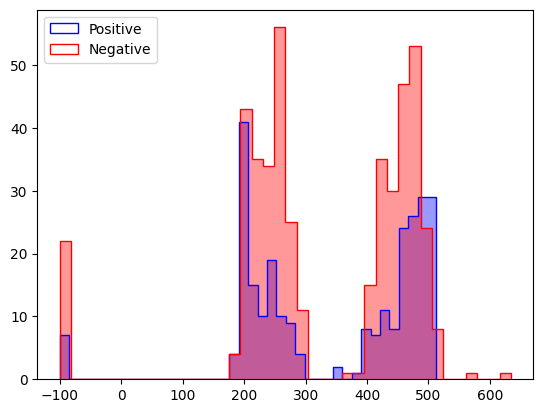

In [70]:
density = False#True
bins = 40
plt.hist(data['first_exposure_date'][y==1],histtype='step', bins = bins, color = 'blue', density=density, label = 'Positive')
plt.hist(data['first_exposure_date'][y==1],histtype='stepfilled', bins = bins, alpha = 0.4, color='blue', density=density)
plt.hist(data['first_exposure_date'][y==0],histtype='step', bins = bins, color = 'red', density=density, label='Negative')
plt.hist(data['first_exposure_date'][y==0],histtype='stepfilled', bins = bins, alpha = 0.4, color='red', density=density)
plt.legend()
plt.show()

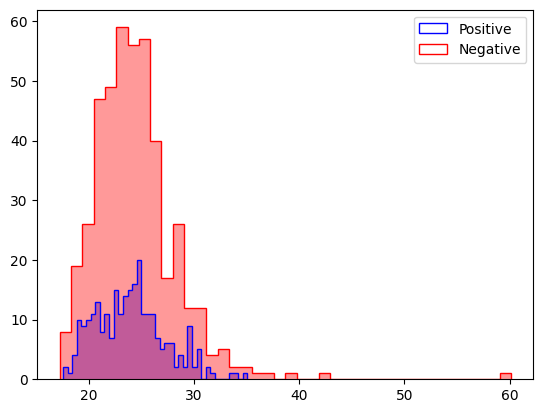

In [71]:
density = False#True
bins = 40
plt.hist(data['bmi'][y==1],histtype='step', bins = bins, color = 'blue', density=density, label = 'Positive')
plt.hist(data['bmi'][y==1],histtype='stepfilled', bins = bins, alpha = 0.4, color='blue', density=density)
plt.hist(data['bmi'][y==0],histtype='step', bins = bins, color = 'red', density=density, label='Negative')
plt.hist(data['bmi'][y==0],histtype='stepfilled', bins = bins, alpha = 0.4, color='red', density=density)
plt.legend()
plt.show()

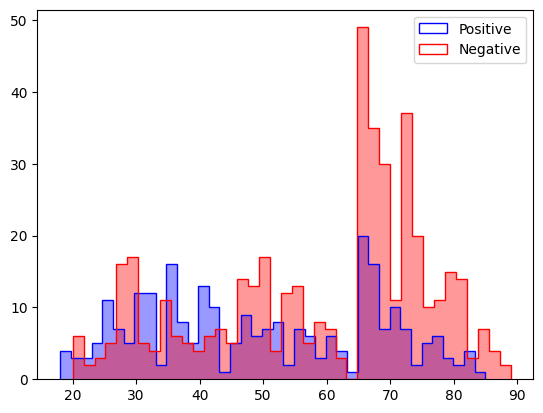

In [72]:
density = False#True
bins = 40
plt.hist(data['age'][y==1],histtype='step', bins = bins, color = 'blue', density=density, label = 'Positive')
plt.hist(data['age'][y==1],histtype='stepfilled', bins = bins, alpha = 0.4, color='blue', density=density)
plt.hist(data['age'][y==0],histtype='step', bins = bins, color = 'red', density=density, label='Negative')
plt.hist(data['age'][y==0],histtype='stepfilled', bins = bins, alpha = 0.4, color='red', density=density)
plt.legend()
plt.show()

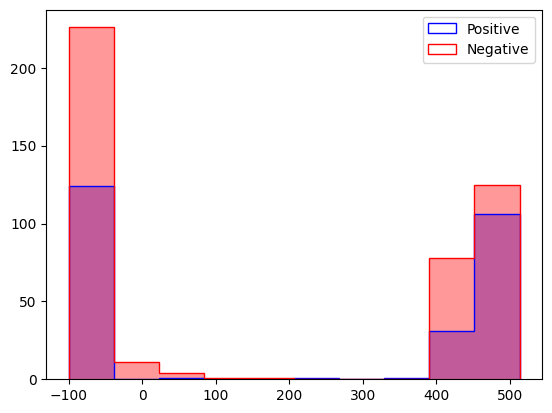

In [73]:
density = False#True
plt.hist(most_recent_infection[y==1],histtype='step', bins = 'auto', color = 'blue', density=density, label = 'Positive')
plt.hist(most_recent_infection[y==1],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='blue', density=density)
plt.hist(most_recent_infection[y==0],histtype='step', bins = 'auto', color = 'red', density=density, label='Negative')
plt.hist(most_recent_infection[y==0],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='red', density=density)
plt.legend()
plt.show()

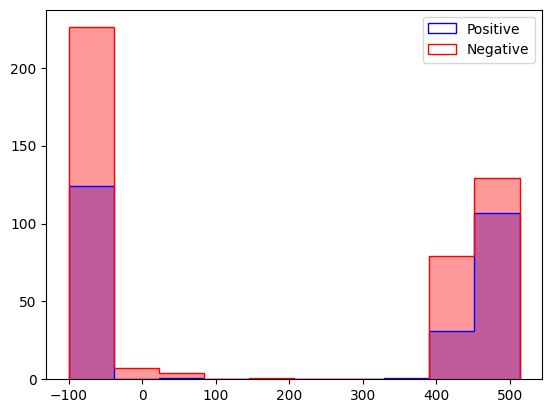

In [74]:
density = False#True
plt.hist(pcr_pos_date[y==1],histtype='step', bins = 'auto', color = 'blue', density=density, label = 'Positive')
plt.hist(pcr_pos_date[y==1],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='blue', density=density)
plt.hist(pcr_pos_date[y==0],histtype='step', bins = 'auto', color = 'red', density=density, label='Negative')
plt.hist(pcr_pos_date[y==0],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='red', density=density)
plt.legend()
plt.show()

pcr_pos_date_2           0.004880
cvd                      0.006141
ab_chuv_igg_s_result     0.006966
ab_chuv_iga_result       0.007983
pcr_pos_sev_1            0.010934
                           ...   
vaccine_date_1           0.174713
employment_4l_Retired    0.183427
vaccine_date_3           0.184993
num_vaccines             0.201410
age                      0.249613
Length: 80, dtype: float64


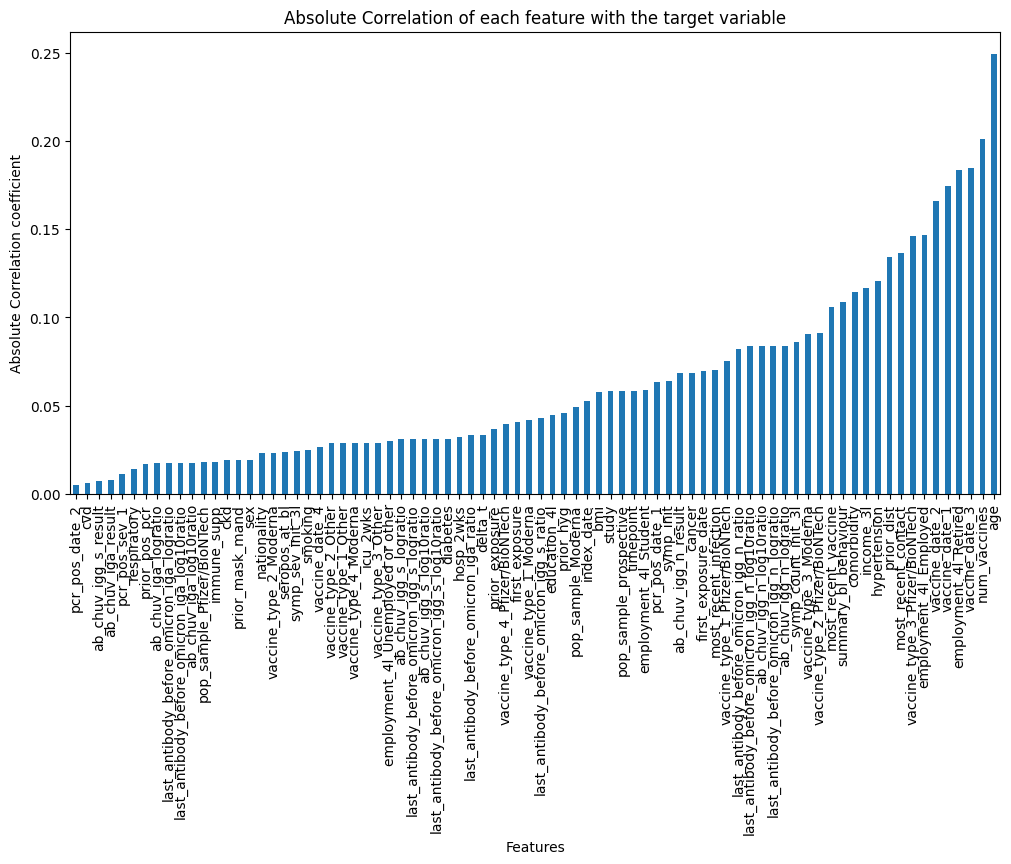

In [75]:
correlations = data.corrwith(y).abs().sort_values()
print(correlations)
correlations.plot(kind='bar', figsize=(12, 6))
plt.title('Absolute Correlation of each feature with the target variable')
plt.xlabel('Features')
plt.ylabel('Absolute Correlation coefficient')
plt.show()

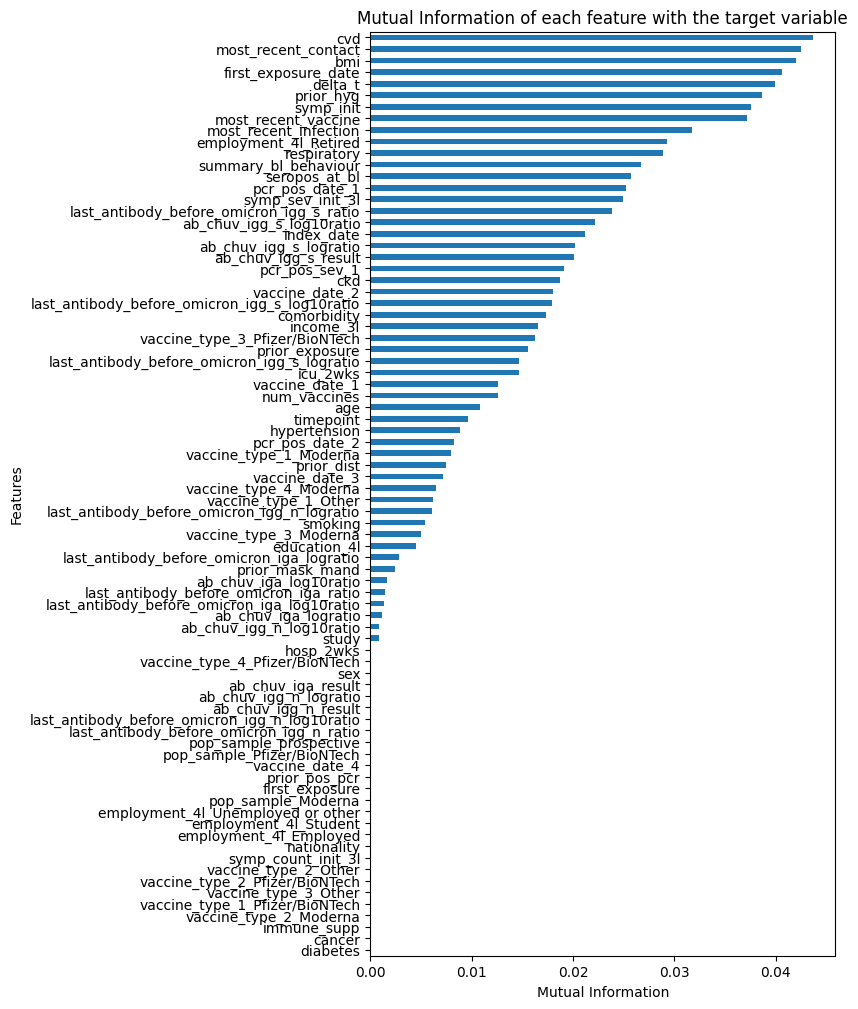

In [76]:
from sklearn.feature_selection import mutual_info_classif

# Calculate mutual information
mi = mutual_info_classif(data, y, discrete_features='auto')
mi_series = pd.Series(mi, index=data.columns).sort_values()

# Plot mutual information
mi_series.plot(kind='barh', figsize=(6, 12))
plt.title('Mutual Information of each feature with the target variable')
plt.ylabel('Features')
plt.xlabel('Mutual Information')
plt.show()

In [77]:
raw_data['pcr_pos_date_1']


record_id
1       2020-08-06
2       2020-08-06
3       2020-08-06
5       2020-08-06
8       2020-08-08
           ...    
5409           NaN
5410           NaN
5411           NaN
5413           NaN
5417           NaN
Name: pcr_pos_date_1, Length: 710, dtype: object

In [78]:
raw_data['prior_exposure'].value_counts()

prior_exposure
No     667
Yes     43
Name: count, dtype: int64

cvd                     0.006141
ab_chuv_igg_s_result    0.006966
pcr_pos_sev_1           0.007981
ab_chuv_iga_result      0.007983
respiratory             0.014023
                          ...   
vaccine_date_2          0.196906
vaccine_date_3          0.198889
num_vaccines            0.209286
vaccine_date_1          0.236237
age                     0.249594
Length: 80, dtype: float64


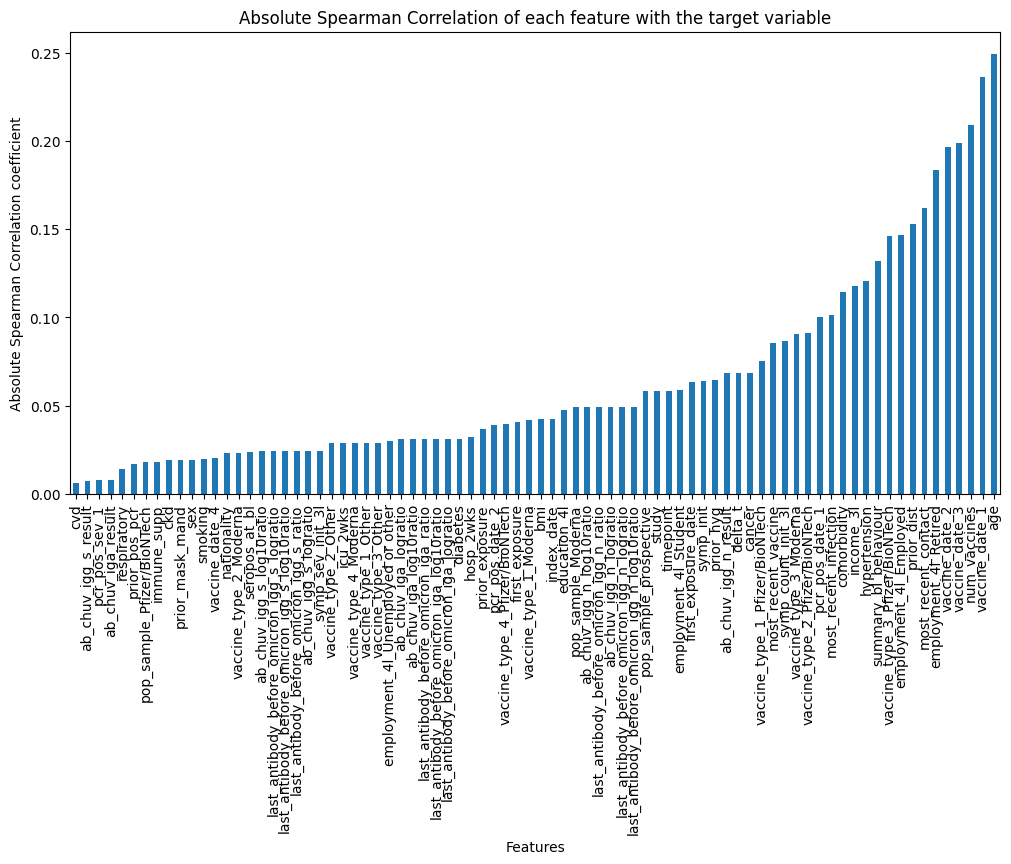

In [79]:
spearman_corr = data.corrwith(y, method='spearman').abs().sort_values()
print(spearman_corr)
spearman_corr.plot(kind='bar', figsize=(12, 6))
plt.title('Absolute Spearman Correlation of each feature with the target variable')
plt.xlabel('Features')
plt.ylabel('Absolute Spearman Correlation coefficient')
plt.show()

In [80]:
zsac = data[data['study']==0]
zvac = data[data['study']==1]

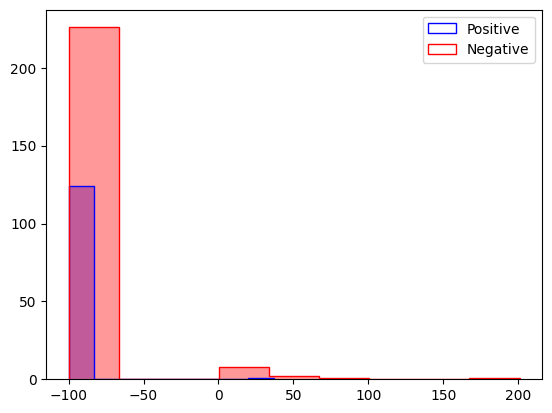

In [81]:
density = False#True
plt.hist(zvac['pcr_pos_date_1'][y==1],histtype='step', bins = 'auto', color = 'blue', density=density, label = 'Positive')
plt.hist(zvac['pcr_pos_date_1'][y==1],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='blue', density=density)
plt.hist(zvac['pcr_pos_date_1'][y==0],histtype='step', bins = 'auto', color = 'red', density=density, label='Negative')
plt.hist(zvac['pcr_pos_date_1'][y==0],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='red', density=density)
plt.legend()
plt.show()

In [82]:
raw_data['first_exposure_date'].isna().sum()

29

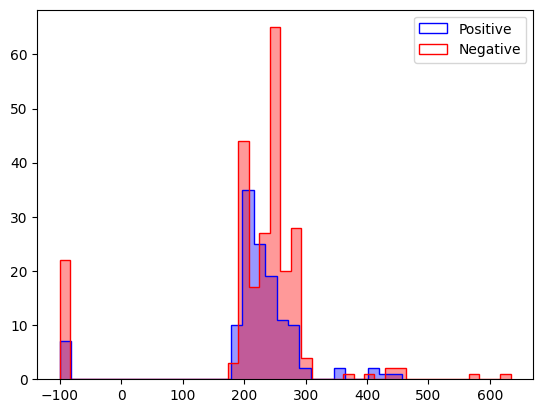

In [83]:
density = False#True
plt.hist(zvac['first_exposure_date'][y==1],histtype='step', bins = 'auto', color = 'blue', density=density, label = 'Positive')
plt.hist(zvac['first_exposure_date'][y==1],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='blue', density=density)
plt.hist(zvac['first_exposure_date'][y==0],histtype='step', bins = 'auto', color = 'red', density=density, label='Negative')
plt.hist(zvac['first_exposure_date'][y==0],histtype='stepfilled', bins = 'auto', alpha = 0.4, color='red', density=density)
plt.legend()
plt.show()

In [84]:
y_pred = data['first_exposure_date'] > 480
accuracy = (y_pred == y).mean()
balanced_accuracy = balanced_accuracy_score(y, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")

Accuracy: 0.65
Balanced Accuracy: 0.56


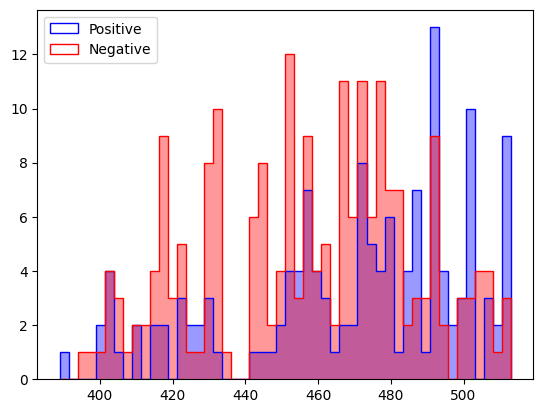

In [85]:
density = False  # True
bins = 50

# Calculate bins based on the first histogram
hist_data, bin_edges = np.histogram(zsac['pcr_pos_date_1'][y == 1], bins=bins, density=density)

plt.hist(zsac['pcr_pos_date_1'][y == 1], histtype='step', bins=bin_edges, color='blue', density=density, label='Positive')
plt.hist(zsac['pcr_pos_date_1'][y == 1], histtype='stepfilled', bins=bin_edges, alpha=0.4, color='blue', density=density)
plt.hist(zsac['pcr_pos_date_1'][y == 0], histtype='step', bins=bin_edges, color='red', density=density, label='Negative')
plt.hist(zsac['pcr_pos_date_1'][y == 0], histtype='stepfilled', bins=bin_edges, alpha=0.4, color='red', density=density)
plt.legend()
plt.show()

In [86]:
y_pred = data['pcr_pos_date_1'] >480
accuracy = (y_pred == y).mean()
balanced_accuracy = balanced_accuracy_score(y, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")

Accuracy: 0.65
Balanced Accuracy: 0.56


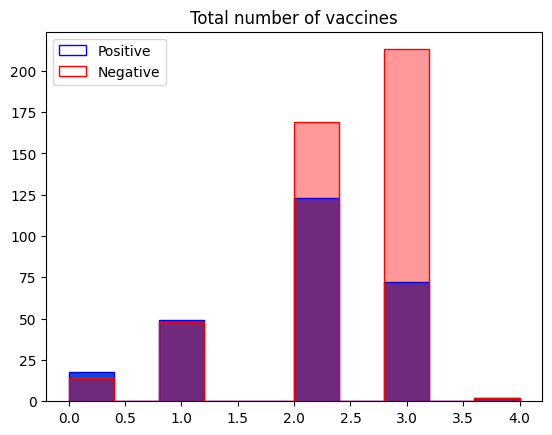

In [87]:
bins = 10
density = False


bins = plt.hist(data['num_vaccines'][y==1], bins=bins, density=density)[1]

plt.hist(data['num_vaccines'][y==1], histtype='step', bins=bins, color='blue', density=density, label='Positive')
plt.hist(data['num_vaccines'][y==1], histtype='stepfilled', bins=bins, alpha=0.4, color='blue', density=density)
plt.hist(data['num_vaccines'][y==0], histtype='step', bins=bins, color='red', density=density, label='Negative')
plt.hist(data['num_vaccines'][y==0], histtype='stepfilled', bins=bins, alpha=0.4, color='red', density=density)
plt.legend()
plt.title("Total number of vaccines")
plt.show()

In [88]:
((data['num_vaccines']<1.5) == y).mean()

0.6352112676056338

In [89]:
from sklearn.metrics import balanced_accuracy_score

y_pred = data['num_vaccines'] < 1.5
accuracy = (y_pred == y).mean()
balanced_accuracy = balanced_accuracy_score(y, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")

Accuracy: 0.64
Balanced Accuracy: 0.56


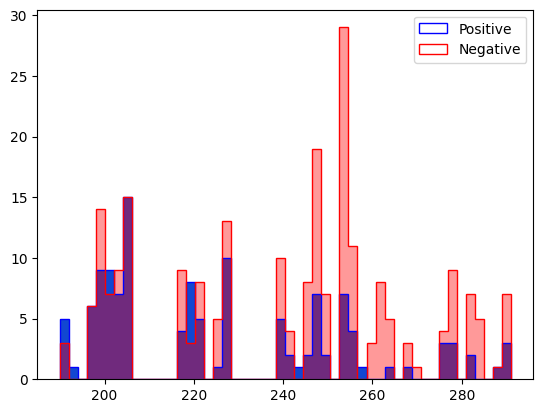

In [90]:
bins = 50
density = False


bins = plt.hist(zvac['index_date'][y==1], bins=bins, density=density)[1]

plt.hist(zvac['index_date'][y==1], histtype='step', bins=bins, color='blue', density=density, label='Positive')
plt.hist(zvac['index_date'][y==1], histtype='stepfilled', bins=bins, alpha=0.4, color='blue', density=density)
plt.hist(zvac['index_date'][y==0], histtype='step', bins=bins, color='red', density=density, label='Negative')
plt.hist(zvac['index_date'][y==0], histtype='stepfilled', bins=bins, alpha=0.4, color='red', density=density)
plt.legend()
plt.show()